<a href="https://colab.research.google.com/github/andrewbhennessy/CS4641-Customer-Segmentation-Analysis/blob/main/Final_Project_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import datetime
import sklearn as skl
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab import files
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import plotly.graph_objs as go
from plotly import tools
from plotly.subplots import make_subplots

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Customer Data segmentation

Link to Our Data: https://www.kaggle.com/carrie1/ecommerce-data

How to Mount Data:
1. Follow the Instructions in the Auth Cell
2. Click the file icon
3. Navigate to drive then the folder that I have shared should be CS4641 something
4. right click on the file and copy path to the file and input into the next code cell as the first paramater in quotes. 

Example:


```
data = pd.read_csv('/content/drive/My Drive/CS4641 Customer Data Segmentation/data.csv', encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceID': str})
```



In [ ]:
init_df = pd.read_csv("/content/drive/My Drive/CS4641 Customer Data Segmentation/data.csv", encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceID': str})




# 1. Introduction/Background

> The COVID-19 pandemic has greatly affected the way all companies advertise for their businesses. Now more than ever, online presence and advertising are necessary to attract customers. While each customer is unique, a similar group of customers can be identified based on their purchase history. By grouping customers together based on recency, frequency, and monetary value we can create specific advertisements and incentives to maximize the revenue generated by a company. This is almost always more successful than creating generalized incentives and other types of advertisements aimed at the entire population.

# 2. Problem definition

> Our project will use customer spending datasets to group customers together based on 3 features: recency, frequency, and monetary value. This will allow advertising to become specialized to each cluster. With this, companies can target these groups and make advertisements and incentives specifically aimed at each of them. By analyzing the spending habits in each cluster, companies can more efficiently allocate their advertising funds.

# 3. Data Collection

> ## 3.1 Data Abstract
> ## 3.2 Data Cleaning Procedure
1. Remove Nan Customer ID datapoints
2. deal with negative quantities
3. Weight Discounts, Cancelled Orders, Regular orders 
>> ``` weights = {'D':0.5,'C':-1,'R':1} ```
4. Make new database based upon each customer with
>> 4.1 RFM Segmentation
>>> 4.1.1 Recency (how recent did customer buy from store?)
>>> 4.1.2 Frequency (how often did customer buy from store?)
>>> 4.1.3 Monetary (how much did customer spend?)
>> 4.2 divide into tiered groups (4 tiers)
>>> 4.2.1 K-means

> ## 3.3 Summary of Data


In [ ]:
init_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


After loading up our dataset, let's check for its size

In [ ]:
init_df.shape

(541909, 8)

As we can see, our initial dataset contains 541,909 total datapoints, each with 8 features. Now let's make sure our data is nice and clean. We are going to have to take our information given to construct a new dataset based upon the customers. If we are going to do that, then we can't be working with datapoints with a null (NaN) CustomerID. Let's check to see if there are any to remove. I found this snippet on stackoverflow that uses pandas to show null values 

In [ ]:
init_df[init_df.isnull().T.any().T]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,12/9/2011 10:26,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,12/9/2011 10:26,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,12/9/2011 10:26,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,12/9/2011 10:26,10.79,NaN,United Kingdom


There are 135,080 null CustomerIDs, wow! Let's remove them all, thankfully we still have a ton of data to work with.

In [ ]:
init_df.dropna(subset=["CustomerID"], inplace=True)
init_df.drop_duplicates(inplace=True)
len(np.unique(init_df['CustomerID']))

4372

Now upon further analysis, It looks like some of the quantities in the dataset are < 0. Let's analyze this

In [ ]:
init_df[init_df['Quantity'] < 0]

We can see that there are over 8,000 orders that have negative quantity. From what it looks like, the 'C' inside the InvoiceNo means that this invoice has been canceled. There are also some special StockCodes like 'D' and 'M' that have negative quantities associated with it. There are three types of situations here. First, an order can be bought then canceled fully. Second, there could be orders that have negative quantity that aren't associated with a refund at all. Third, there could be orders that were bought then canceled partially. Let's take care of these 3 situations. Upon further research, our best method is to introduce a new feature which notates how many of that invoice's Quantity was refunded. This idea was inspired by Fabien Daniel's work in his Notebook on our same customer segmentation dataset. https://www.kaggle.com/fabiendaniel/customer-segmentation

In [ ]:
updated_df = init_df.copy(deep=True)
updated_df['QuantityRefunded'] = 0

remove_index_list = []

for index, row in init_df.iterrows():
    if row['Quantity'] < 0:
        #Finds all opposites for a given datapoint. There either won't be any (no match),
        #one match (full refund), or more than one (partial refund) we use .copy() so that we don't accidentally change the df
        refunded = init_df[(init_df['CustomerID'] == row['CustomerID']) & (init_df['StockCode'] == row['StockCode']) &
                           (init_df['InvoiceDate'] == row['InvoiceDate']) & (init_df['Quantity'] > 0)].copy()
        matches = refunded.shape[0] #number of rows represents how many matches we got
        
        if matches == 1:
            #full refund, update QuantityRefunded of the refunded datapoint and add current index to remove list
            updated_df.loc[refunded.index[0],'QuantityRefunded'] = -row['Quantity']
        else:
            #more than one match, find the latest index which fits the quantity 
            refunded.sort_index(axis=0 ,ascending=False, inplace = True)        
            for i, r in refunded.iterrows():
                if r['Quantity'] >= -row['Quantity']: 
                    updated_df.loc[i, 'QuantityRefunded'] = -row['Quantity']
                    break 
        remove_index_list.append(index)        

Now that we have found all the datapoints to remove / update the dataframe with, let's remove them and view our new feature. Let's also make sure that there are no longer any other quantities that are less than 0. While we are at it let's introduce another feature called 'Profit' that represents the total money gained from this purchase. This will be equal to ```UnitPrice * (Quantity - QuantityRefunded)```

In [ ]:
updated_df.drop(remove_index_list, inplace=True)
leftovers = updated_df[updated_df['Quantity'] < 0]
print('there are ', len(leftovers), ' leftovers in the dataset... removing them')
updated_df.drop(leftovers.index, inplace=True)
updated_df['Profit'] = updated_df['UnitPrice'] * (updated_df['Quantity'] - updated_df['QuantityRefunded'])

We noticed earlier that there were some weird stock codes such as 'M' and 'D'. Let's make sure that there aren't anymore laying around, and if so, let's remove them!

In [ ]:
#get all unique stock code values
stonk_codes = updated_df[updated_df['StockCode'].str.contains('^[A-Za-z]+')]['StockCode'].unique()
updated_df = updated_df[~updated_df['StockCode'].isin(stonk_codes)]
stonk_codes

We can finally start to morph this dataset into a more customer-based one. After doing research, our team stumbled upon an interesting segmentation algorithm designed to be used for customer segmentation called RFM. You can read more about it at https://www.optimove.com/resources/learning-center/rfm-segmentation. In our final dataset, each customer is going to be given a score for Recency, Frequency, and Monetary. Recency represents how recent this customer last shopped using this e-commerce site. Frequency represents how often this customer shops using this e-commerce site. And Monetary will represent how much money this customer has spent on this e-commerce site.

Since this data is from the early 2010's, let's not find the recency with respect to 2020, but rather with respect to the chronologically last InvoiceDate.

In [ ]:
updated_df['InvoiceDate'] = pd.to_datetime(updated_df['InvoiceDate'])
latest = updated_df['InvoiceDate'].max() + datetime.timedelta(days=1)
latest

Using custom aggregations, we can pass a ditionary of functions for each feature into the ```.agg()``` function in order to build our RFM dataframe. We want to sum up all the ```Profit``` tags for each invoice all the while supplying a recency value for each invoice, then change our dataset to account for each customer's invoices' data using ```.agg()``` so we can correctly find each customers average Recency, total Frequency, and total Monetary

In [ ]:
#build recency 
try:
  rfm_df = pd.read_csv("/content/drive/My Drive/CS4641 Customer Data Segmentation/RFM.csv", encoding="ISO-8859-1", dtype={'CustomerID': int,'R': float, 'F':int, 'M':float})
except:
  recency_agg = {
      'Profit' : 'sum',
      'CustomerID' : lambda x : x.iloc[0], #lambda that returns the customerID, we use this to groupby later
      'InvoiceDate': lambda x : x.iloc[0] #lambda that returns the InvoiceDate
  }
  rfm_df = updated_df.groupby('InvoiceNo').agg(recency_agg) 
  rfm_df['R'] = pd.to_timedelta(latest - rfm_df['InvoiceDate']).astype('timedelta64[D]')
  frequency_monetary_agg = {
      'R' : 'mean', #recency agg, gets the average recency for when a customer last went to the shop
      'InvoiceDate' : lambda x : len(x), #frequency agg, gets how many invoices a customer made
      'Profit' : 'sum' #monetary agg, sums up all profits for every invoice a customer is associated with
  }
  rfm_df = rfm_df.groupby('CustomerID').agg(frequency_monetary_agg) #performs agg on a customer basis
  rfm_df.columns = ['R','F','M']
  try: 
    rfm_df.to_csv('/content/drive/My Drive/CS4641 Customer Data Segmentation/RFM.csv')
  except:
    print("Save Failure. Please check!!")

## Outlier Treatment 
> for Monetary Amount




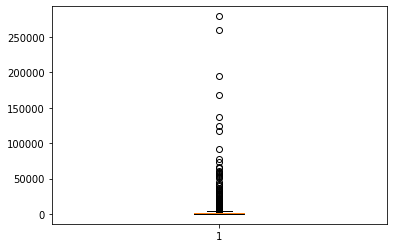

In [ ]:
# outlier treatment for Amount
plt.boxplot(rfm_df.M)
Q1 = rfm_df.M.quantile(0.25)
Q3 = rfm_df.M.quantile(0.75)
IQR = Q3 - Q1
rfm_df = rfm_df[(rfm_df.M >= (Q1 - 1.5*IQR)) & (rfm_df.M <= (Q3 + 1.5*IQR))]

> Outlier Treatment for Frequency


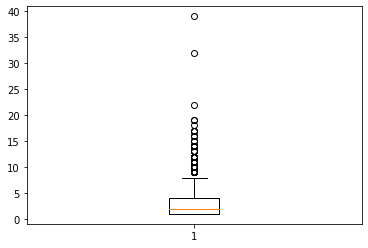

In [ ]:
# outlier treatment for Frequency
plt.boxplot(rfm_df.F)
Q1 = rfm_df.F.quantile(0.25)
Q3 = rfm_df.F.quantile(0.75)
IQR = Q3 - Q1
rfm_df = rfm_df[(rfm_df.F >= Q1 - 1.5*IQR) & (rfm_df.F <= Q3 + 1.5*IQR)]

> Outlier Treatment for Recency

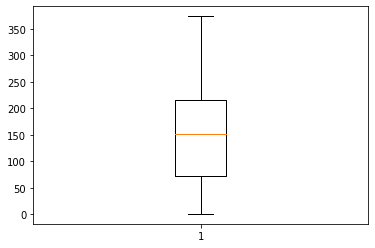

In [ ]:
# outlier treatment for Recency
plt.boxplot(rfm_df.R)
Q1 = rfm_df.R.quantile(0.25)
Q3 = rfm_df.R.quantile(0.75)
IQR = Q3 - Q1
rfm_df = rfm_df[(rfm_df.R >= Q1 - 1.5*IQR) & (rfm_df.R <= Q3 + 1.5*IQR)]

> Summary of RFM after Outlier Treatment for R,F,M

In [ ]:
rfm_df.head()

,CustomerID,R,F,M
2,12348,250.250000,4,1437.24
3,12349,19.000000,1,1457.55
4,12350,310.000000,1,294.40
5,12352,185.285714,7,1385.74
6,12353,204.000000,1,89.00


> ## Scaling our RFM Data


In [ ]:
# standardise all parameters
RFM_norm1 = rfm_df.drop(["CustomerID"], axis=1)

standard_scaler = StandardScaler()
RFM_norm1 = standard_scaler.fit_transform(RFM_norm1)

In [ ]:
 RFM_norm1 = pd.DataFrame(RFM_norm1)
RFM_norm1.columns = ['R','F','M']
RFM_norm1.head()

array([-0.85148339, -0.29918974,  0.25310392,  0.80539757,  1.35769122,
        1.90998488,  2.46227853,  3.01457218])

# 4. Methods (K-MEANS and DBSCAN)

> We will be testing K-means, DBSCAN, and GMM to specify our groups. Using K-means method, points are assigned to their nearest centroid based on their Euclidean distance. The points assigned to the same centroid form a cluster. After the clusters are formed, a new centroid is calculated for each cluster by taking the mean of the cluster. This is repeated until the centroids can no longer move any further. K-means will include all data points in its clustering groups. The Elbow method can be used to find the optimal number of clusters. A disadvantage to K-means is that the cluster groups will all be more or less circular, whereas other forms of clustering can create irregular-shaped cluster groups. In addition, K-means is sensitive to outliers since new centroids are calculated every iteration and extreme values can easily affect the location of centroids.

 >DBSCAN is another performative clustering algorithm that categorizes nearby points into same cluster. It takes two parameters which are known as epsilon and minimum number of points.  Epsilon refers to the required distance between two points in order for them to be classified as the same cluster. Minimum number of points is required number of data points to form a cluster. Typically, minimum number of points must be more than the number of dimensions in a data set and the higher dimensions in a data set, the more minimum number of points required. In contrast to K-means, DBSCAN doesn’t require to input the number of cluster and is capable of handling outliers. In fact, it will produce as many clusters as needed depending on the values of parameters. A weakness of DBSCAN is that it struggles to appropriately separate a data set if the data set contains many groups with similar density.

 > Last method we will be testing is Gaussian Mixture Models (GMM). While K-means is only capable of clustering in circular fashion, GMM can handle oblong clusters. GMM groups a data set in a similar way as K-means but GMM takes variance into account since GMM involves mixture of multiple Gaussian distributions. Also, GMM is competent in performing soft classification which allows to reveal not only the cluster a data point belongs to but also the probabilities of all potential clusters it may belong to.

> Visualization of K-means

In [ ]:
our_number_of_clusters = 8
model = KMeans(n_clusters = our_number_of_clusters, max_iter=50)
kmeans_clusters = model.fit_predict(RFM_norm1)
np.unique(kmeans_clusters)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32)

In [ ]:
# 3d scatterplot using plotly
Scene = dict(xaxis = dict(title  = 'Recency'),yaxis = dict(title  = 'Frequency'),zaxis = dict(title  = 'Monetary'))

x = RFM_norm1[['R','F','M']].values

labels = kmeans_clusters
trace = go.Scatter3d(x=x[:, 0], y=x[:, 1], z=x[:, 2], mode='markers',marker=dict(color = labels, size= 5, line=dict(color= 'black',width = 10)))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene,height = 800,width = 800)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

>Visualization of DBSCAN

In [ ]:
our_eps = .45
our_minPts = 4
dbscan_clusters = DBSCAN(eps=our_eps, min_samples=our_minPts, metric='euclidean').fit_predict(RFM_norm1)
np.unique(dbscan_clusters)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [ ]:
# 3d scatterplot using plotly
Scene = dict(xaxis = dict(title  = 'Recency'),yaxis = dict(title  = 'Frequency'),zaxis = dict(title  = 'Monetary'))

x = RFM_norm1[['R','F','M']].values

labels = dbscan_clusters
trace = go.Scatter3d(x=x[:, 0], y=x[:, 1], z=x[:, 2], mode='markers',marker=dict(color = labels, size= 5, line=dict(color= 'black',width = 10)))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene,height = 800,width = 800)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

> GMM

In [ ]:
gmm_clusters = GaussianMixture(n_components=8).fit_predict(RFM_norm1)
np.unique(gmm_clusters)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [ ]:
# 3d scatterplot using plotly
Scene = dict(xaxis = dict(title  = 'Recency'),yaxis = dict(title  = 'Frequency'),zaxis = dict(title  = 'Monetary'))

x = RFM_norm1[['R','F','M']].values

labels = gmm_clusters
trace = go.Scatter3d(x=x[:, 0], y=x[:, 1], z=x[:, 2], mode='markers',marker=dict(color = labels, size= 5, line=dict(color= 'black',width = 10)))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene,height = 800,width = 800)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

# 5 Results (See 6 Discussion for results in context)
> Silhouette Analysis


In [ ]:
sse_ = []
for k in range(2, 21):
    kmeans = KMeans(n_clusters=k).fit(RFM_norm1)
    sse_.append([k, silhouette_score(RFM_norm1, kmeans.labels_)])

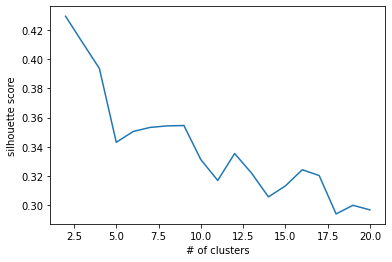

In [ ]:
plt.xlabel("# of clusters")
plt.ylabel("silhouette score")
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1]);

> Sum of Squared Distances

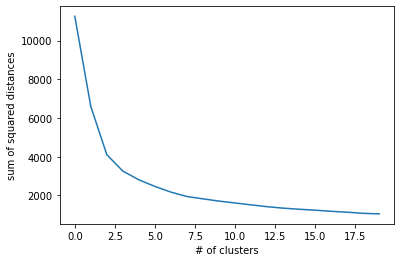

In [ ]:
# sum of squared distances
ssd = []
for num_clusters in list(range(1,21)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(RFM_norm1)
    ssd.append(model_clus.inertia_)
plt.xlabel("# of clusters")
plt.ylabel("sum of squared distances")
plt.plot(ssd)



> Cluster Magnitudes



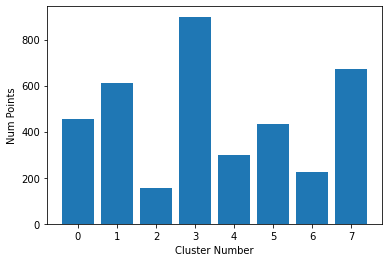

In [ ]:
ticks = [i for i in range(our_number_of_clusters)]
label_list = labels.tolist()
label_count = []
for i in range(our_number_of_clusters):
  label_count.append(label_list.count(i))
#print(label_list.count(0),label_list.count(1),label_list.count(2))
plt.bar(ticks,label_count)
plt.xlabel('Cluster Number')
plt.ylabel('Num Points')
plt.show()


> EPS estimation

Text(0, 0.5, 'Distance')

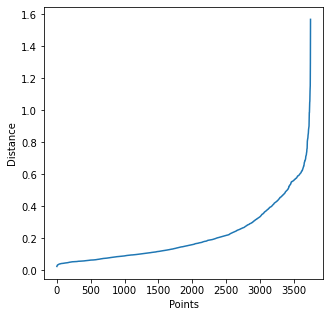

In [ ]:
nearest_neighbors = NearestNeighbors(n_neighbors=11)
neighbors = nearest_neighbors.fit(RFM_norm1)
distances, indices = neighbors.kneighbors(RFM_norm1)
distances = np.sort(distances[:,10], axis=0)
fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")

> Analyzing K-Means clusters

In [ ]:
compiled_rfm_kmeans = rfm_df
compiled_rfm_kmeans['Cluster'] = kmeans_clusters
print('K-Means cluster analysis')
for i in range(8):
  print(f'----- Data for cluster {i} -----')
  cluster_i_df = compiled_rfm_kmeans[compiled_rfm_kmeans['Cluster'] == i]
  average_recency = cluster_i_df['R'].mean()
  average_frequency = cluster_i_df['F'].mean()
  average_monetary = cluster_i_df['M'].mean()
  print(f'  r_avg: {average_recency}\n  f_avg = {average_frequency}\n  m_avg = {average_monetary}')



K-Means cluster analysis
----- Data for cluster 0 -----
  r_avg: 300.0760928961748
  f_avg = 1.2508196721311475
  m_avg = 330.1711803278689
----- Data for cluster 1 -----
  r_avg: 51.45550611790879
  f_avg = 1.2324805339265852
  m_avg = 335.0750166852056
----- Data for cluster 2 -----
  r_avg: 147.47099853157124
  f_avg = 3.6343612334801763
  m_avg = 2341.533480176213
----- Data for cluster 3 -----
  r_avg: 208.9473180076629
  f_avg = 3.5126436781609196
  m_avg = 953.6032183908046
----- Data for cluster 4 -----
  r_avg: 159.33400818926293
  f_avg = 6.726114649681529
  m_avg = 2798.230700636941
----- Data for cluster 5 -----
  r_avg: 148.9850351550016
  f_avg = 6.073825503355705
  m_avg = 1412.5095302013424
----- Data for cluster 6 -----
  r_avg: 176.29104477611935
  f_avg = 1.6164179104477612
  m_avg = 405.8501641791047
----- Data for cluster 7 -----
  r_avg: 79.98402930402926
  f_avg = 2.9912087912087912
  m_avg = 953.9849670329672


> Analyzing GMM clusters

In [ ]:
compiled_rfm_gmm = rfm_df
compiled_rfm_gmm['Cluster'] = gmm_clusters
print('GMM cluster analysis')
for i in range(8):
  print(f'----- Data for cluster {i} -----')
  cluster_i_df = compiled_rfm_gmm[compiled_rfm_gmm['Cluster'] == i]
  average_recency = cluster_i_df['R'].mean()
  average_frequency = cluster_i_df['F'].mean()
  average_monetary = cluster_i_df['M'].mean()
  print(f'  r_avg: {average_recency}\n  f_avg = {average_frequency}\n  m_avg = {average_monetary}')

GMM cluster analysis
----- Data for cluster 0 -----
  r_avg: 186.50069881201955
  f_avg = 3.4046121593291403
  m_avg = 797.4357861635219
----- Data for cluster 1 -----
  r_avg: 145.70473111658458
  f_avg = 3.689655172413793
  m_avg = 2429.552155172415
----- Data for cluster 2 -----
  r_avg: 46.94086021505376
  f_avg = 2.0
  m_avg = 453.1176344086023
----- Data for cluster 3 -----
  r_avg: 156.6421768707483
  f_avg = 1.0
  m_avg = 308.36387755102083
----- Data for cluster 4 -----
  r_avg: 174.67439516129036
  f_avg = 7.07258064516129
  m_avg = 2747.8090322580647
----- Data for cluster 5 -----
  r_avg: 63.75041459369818
  f_avg = 3.288557213930348
  m_avg = 844.1455721393032
----- Data for cluster 6 -----
  r_avg: 153.78116933689358
  f_avg = 5.626168224299065
  m_avg = 1395.2064018691594
----- Data for cluster 7 -----
  r_avg: 182.53159557661928
  f_avg = 2.0
  m_avg = 673.0766508688782


# 6. Discussion

>Prior to applying any clustering methods, we underwent multiple data cleaning processes, calculations, and outlier treatment to prepare our data for a new powerful method called RFM segmentation. RFM segmentation allowed our data set to be finalized so that each data point (customer) has three features: recency, frequency and monetary. Using these three features, we applied K-means clustering analysis to group each customer into a certain number of clusters. In order to test for the optimal number of clusters, we visualized silhouette coefficients for over a range from 2 to 15 clusters as well as the sum of squared distances for elbow test. After analyzing two graphs, we figured the optimal number of clusters for our dataset to be 8 with a silhouette coefficient around 0.36. Using these values, we tested K-means with 8 clusters and obtained a visualization as well as the average feature values for each cluster as shown in the results section. The average values for each feature are not normalized so the magnitudes of each average are independent from other features’ averages. By examining the values of averages, we can characterize each cluster as below:

>Cluster 0: Inactive, One time, Low-spending customers (Worst)

>Cluster 1: New, One time, Low-spending customers

>Cluster 2: Fairly recent, Moderately Frequent, High-spending customers

>Cluster 3: Inactive, Moderately Frequent, Moderate-spending customers

>Cluster 4: Fairly recent, Frequent, High-spending customers (Best)

>Cluster 5: Fairly recent, Frequent, Moderate-spending customers

>Cluster 6: Fairly recent, one time, Low-spending customers

>Cluster 7: New, Moderately Frequent, Moderate-spending customers

>The figure for K-means cluster magnitudes suggests that large portion of customers in our data set belongs to cluster 3, which depicts that many customers are no longer active in recent time and spent moderate amount of money fairly many times. On the other hand, cluster 4, the best group of customers for the company unfortunately covers the lowest portion of our data set, so better marketing techniques are required to be implemented in order to increase the revenue. 

>After applying K-means, we tested another clustering method, DBSCAN. With epsilon value of 0.45 and minimum number of points of 4, DBSCAN ultimately produced 12 clusters. Unfortunately, the visualization of these clusters suggests that this method did not produce a pleasant outcome since the clusters seemed to be formed based off of only frequency score. We suspect this failure is due to our data set having too many groups of customers with similar densities. Since DBSCAN uses densities to classify each data point, it will perform well with a data set that has a large gap of densities among the clusters. 

>Last method we tested was GMM. Similar to K-means, we used 8 clusters to visualize how clusters are formed from this method. By looking at the average feature scores for each cluster we can categorized each cluster as such:

>Cluster 0: Fairly recent, Moderately Frequent, Low-spending customers 

>Cluster 1: Fairly recent, Moderately Frequent, High-spending customers

>Cluster 2: New, Moderately Frequent, Low-spending customers

>Cluster 3: Fairly recent, One time, Low-spending customers(Worst)

>Cluster 4: Fairly recent, Frequent, High-spending customers (Best)

>Cluster 5: New, Moderately Frequent, Low-spending customers

>Cluster 6: Fairly recent, Frequent, Moderate-spending customers

>Cluster 7: Fairly recent, Moderately Frequent, Low-spending customers

>Although it was hardly visible in the graph, we figured GMM did not optimally partition the data. As seen above, there are many clusters that share similar average recency score; most clusters referred to fairly recent customers and had lower range of average recency score compared to the clusters made from K-means. This faulty performance of GMM on our data set is potentially due to the flexibility of GMM to account for variances. Since we are only interested in completely classifying our data, GMM might have malfunctioned by attempting to find probabilities of each data point belonging other clusters. Overall, we concluded that K-means offered the most optimal clusters, meaning each cluster had the most distinctive characteristics compared to other clusters.

>Using the clusters produced from the most performative method, K-means, we can organize a better marketing campaigns for each type of customers. For instance, a company can endeavor to regain old, inactive customers such as cluster 0 and 3 by examining their past transaction data to find their preferences and consistently introducing them with new deals and products of their interests. For those who are active and loyal but spend low amount such as cluster 5 and 7, the company needs to ensure they feel comfortable spending more while remaining active and loyal. Therefore, they should never feel forced to buy other pricy products but instead, the company should naturally upsell their spending by offering them with rewards for purchasing expensive products. Cluster 1 and 6 represent a group of customers who are new and transacting with the company for the first time. It is critical for the company to leave a pleasant first impression to those customers in order to attract as many new customers as possible. Welcoming them for their first purchases with coupons can make them feel valued and increase the chance of converting them to regular shoppers. Another marketing tip to attract more new customers is to encourage current shoppers to advertise the company on their personal social networks by incentivizing with rewards. Lastly, cluster 2 and 4 refer to a group of best customers who heavily contribute to the company’s overall revenue. The main target for this group is to encourage them to remain as frequent shoppers by optimizing their experiences and showing appreciation for all their purchases. Also, their previous purchase histories should be thoroughly analyzed to actively communicate with them by sending personalized messages, which can make them feel appreciated even more. 

# 7 Conclusion

>Due to COVID-19 pandemic, there is a significant increase of online shoppers. Therefore, it is crucial for many companies to revisit their advertising techniques to thrive prosperous businesses during this global crisis. Luckily, online commerce facilitates for a company to easily access their customers’ transaction data, which can be used as a data set for many classification methods that group each unique individual to various clusters. There are many methods of classification, but our project incorporated three different algorithms: K-means, DBSCAN, and GMM. Although we reported that K-means was the best method for our data set, this may vary depending on the data set’s size, density, number of features, etc. Therefore, it is highly recommended to attempt many different methods to figure out the best performative method. After most effectively grouping customers into different clusters, a company can scrutinize the characteristics of each cluster and prepare the most suited marketing campaign for each targeted cluster. By doing so, a company will be able to overcome this global pandemic crisis and earn a tremendous benefit in terms of increase in revenue and number of customers.

# 8 References

> 1.  Hossain, Shahadat. “Customer Segmentation Using Centroid Based and Density Based Clustering Algorithms.” Customer Segmentation Using Centroid Based and Density Based Clustering Algorithms - IEEE Conference Publication, 1 Feb. 2018, ieeexplore.ieee.org/document/8275249.

> 2. Modukuru, Pranay. “Customer Segmentation and Acquisition Using Machine Learning.” Medium, Towards Data Science, 19 Apr. 2020, towardsdatascience.com/customer-segmentation-and-acquisition-using-machine-learning-a219ce0ec139.

> 3. Sekhar, Babu B, and Prasanna P Lakshmi. “Customer Data Clustering Using Density Based Algorithm.” Research Gate, International Journal of Engineering & Technology, May 2018, www.researchgate.net/publication/325881992_Customer_Data_Clustering_using_Density_based_algorithm.